In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\rosel\Downloads\New folder\Movie Success Prediction\test_data.csv") 
print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (3755, 28)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


In [3]:
print("\nMissing values before handling:")
print(df.isnull().sum())


Missing values before handling:
color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
movie_imdb_link              0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
aspect_ratio                 0
movie_facebook_likes         0
dtype: int64


In [4]:
# Keep numeric columns numeric (coerce weird strings to NaN)
num_like_cols = [
    'num_critic_for_reviews','duration','director_facebook_likes',
    'actor_3_facebook_likes','actor_1_facebook_likes','gross','num_voted_users',
    'cast_total_facebook_likes','facenumber_in_poster','num_user_for_reviews',
    'budget','title_year','actor_2_facebook_likes','movie_facebook_likes'
]
for c in num_like_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [5]:
# Create ROI target (percent)
df['ROI_pct'] = np.where(df['budget'] > 0, (df['gross'] - df['budget']) / df['budget'] * 100, np.nan)

In [6]:
# Drop rows with undefined ROI target
df = df.dropna(subset=['ROI_pct']).copy()

In [7]:
# Time
df['movie_age'] = 2025 - df['title_year']               # how old the movie is
df['decade']    = (df['title_year'] // 10) * 10         # decade bucket

# Ratios / rates
df['likes_per_actor']   = df['cast_total_facebook_likes'] / df['facenumber_in_poster'].replace(0, np.nan)
df['gross_per_budget']  = df['gross'] / df['budget']
df['reviews_per_vote']  = (df['num_user_for_reviews'] + df['num_critic_for_reviews']) / df['num_voted_users'].replace(0, np.nan)
df['critic_user_ratio'] = df['num_critic_for_reviews'] / df['num_user_for_reviews'].replace(0, np.nan)

# Interactions (simple but useful)
df['duration_x_reviews'] = df['duration'] * df['num_user_for_reviews']

# Genre features (multi-label one-hot)
if 'genres' in df.columns:
    genre_dummies = df['genres'].str.get_dummies(sep='|')
    # Optionally keep only the most common genres to avoid sparsity
    common_genres = genre_dummies.sum().sort_values(ascending=False).head(12).index
    genre_dummies = genre_dummies[common_genres]
    df = pd.concat([df, genre_dummies.add_prefix('genre_')], axis=1)

# Log transforms for skewed columns
for col in ['gross','budget','num_voted_users','movie_facebook_likes','cast_total_facebook_likes']:
    if col in df.columns:
        df[f'log_{col}'] = np.log1p(df[col])

# Clean divisions
df[['likes_per_actor','gross_per_budget','reviews_per_vote','critic_user_ratio']] = (
    df[['likes_per_actor','gross_per_budget','reviews_per_vote','critic_user_ratio']]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

In [8]:
df['target'] = np.where(df['ROI_pct'] > 50, 1, 0)   # 1 = Hit, 0 = Flop

# Remove leakage (post-release features)
leakage_cols = [
    "gross_per_budget", "imdb_score", "reviews_per_vote",
    "critic_user_ratio", "log_movie_facebook_likes", "gross", "log_gross", "ROI_pct"
]

X = df.drop(columns=leakage_cols + ["target"])   # 'target' = Hit/Flop label
y = df["target"]

In [9]:
from catboost import CatBoostClassifier, Pool

feature_columns = X.columns.tolist()

# Identify Categorical Columns
cat_features = X.select_dtypes(include=['object']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create CatBoost Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Train Model
clf = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=200
)

clf.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

0:	learn: 0.7263648	test: 0.7083888	best: 0.7083888 (0)	total: 207ms	remaining: 5m 10s
200:	learn: 0.8828229	test: 0.7643142	best: 0.7683089 (148)	total: 13s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.776298269
bestIteration = 235

Shrink model to first 236 iterations.


In [10]:
from catboost import cv

cv_params = {
    'iterations': 1500,
    'learning_rate': 0.03,
    'depth': 8,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'verbose': 200
}

cv_results = cv(
    pool=train_pool,
    params=cv_params,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42
)

print(cv_results.head())
print("\nMean Accuracy:", cv_results['test-Accuracy-mean'].iloc[-1])

Training on fold [0/5]
0:	learn: 0.7307532	test: 0.6871880	best: 0.6871880 (0)	total: 65.3ms	remaining: 1m 37s
200:	learn: 0.8930504	test: 0.7970050	best: 0.7970050 (193)	total: 12.6s	remaining: 1m 21s
400:	learn: 0.9692052	test: 0.8202995	best: 0.8202995 (391)	total: 25.4s	remaining: 1m 9s
600:	learn: 0.9958385	test: 0.8286190	best: 0.8319468 (479)	total: 37.9s	remaining: 56.7s
800:	learn: 0.9995839	test: 0.8252912	best: 0.8319468 (479)	total: 51s	remaining: 44.5s
1000:	learn: 1.0000000	test: 0.8286190	best: 0.8319468 (479)	total: 1m 3s	remaining: 31.8s
1200:	learn: 1.0000000	test: 0.8286190	best: 0.8336106 (1064)	total: 1m 16s	remaining: 19s
1400:	learn: 1.0000000	test: 0.8319468	best: 0.8336106 (1064)	total: 1m 29s	remaining: 6.3s
1499:	learn: 1.0000000	test: 0.8252912	best: 0.8336106 (1064)	total: 1m 35s	remaining: 0us

bestTest = 0.8336106489
bestIteration = 1064

Training on fold [1/5]
0:	learn: 0.6982938	test: 0.6871880	best: 0.6871880 (0)	total: 56.9ms	remaining: 1m 25s
200:	le

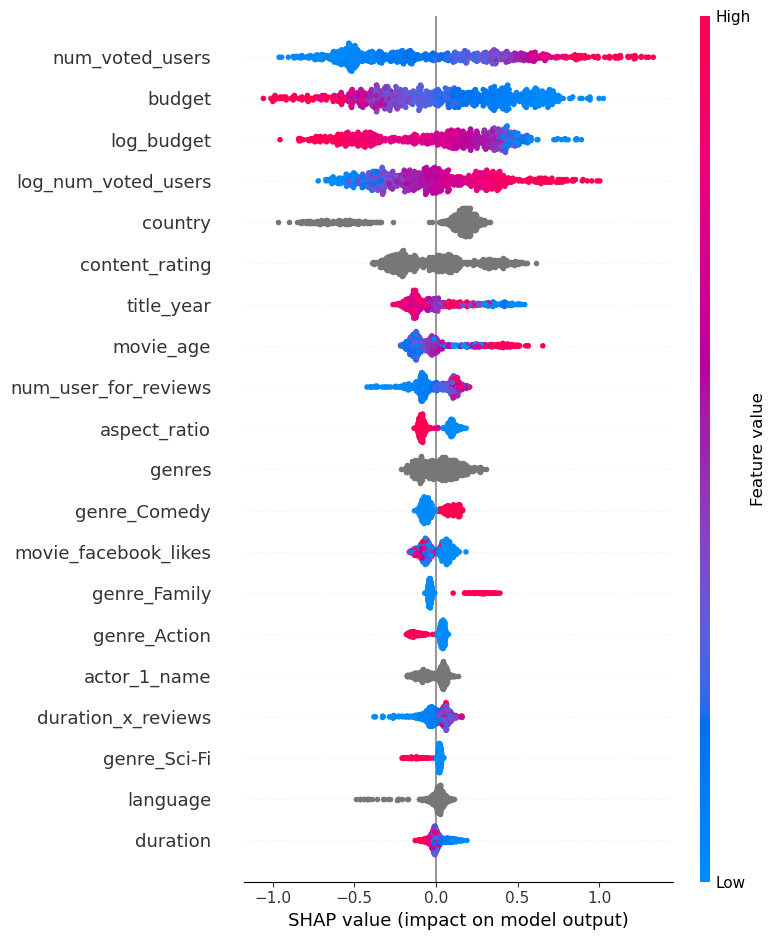

In [11]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Global explanation
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Local explanation (pick one movie)
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

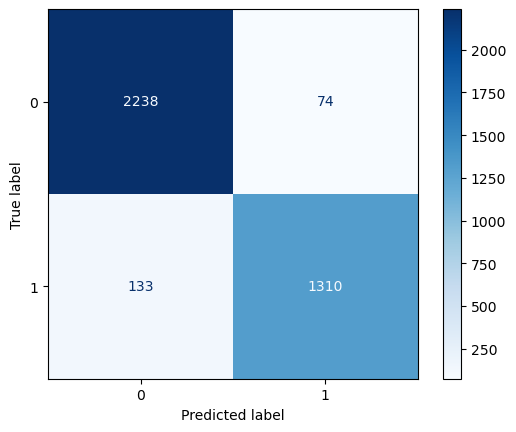

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X)
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Blues")
plt.show()

In [15]:
import joblib
joblib.dump(clf, "hit_flop_model.pkl")
joblib.dump(feature_columns, "feature_columns.pkl")
joblib.dump(cat_features, "cat_features.pkl")
clf.save_model("catboost_model.cbm")

In [16]:
feature_columns = joblib.load("feature_columns.pkl")
cat_features = joblib.load("cat_features.pkl")

In [17]:
clf = CatBoostClassifier()
clf.load_model("catboost_model.cbm")

In [20]:
# Create new movie input (must follow same column order!)
new_movie = pd.DataFrame([{
    "budget": 50_000_000,
    "log_budget": np.log1p(50_000_000),
    "runtime": 120,
    "log_runtime": np.log1p(120),
    "popularity": 50,
    "log_popularity": np.log1p(50),
    "genres": "Action",
    "production_companies": "Marvel Studios",
    "release_month": 5,
    "release_day": 20,
    "release_year": 2024,
    "country": "USA"
}])

# Add missing columns with default values
for col in feature_columns:
    if col not in new_movie.columns:
        new_movie[col] = 0   
        
# Reorder columns to match training
new_movie = new_movie[feature_columns]

# Create CatBoost Pool with correct categorical features
new_pool = Pool(new_movie, cat_features=cat_features)

# Predict
print("Prediction:", model.predict(new_pool))

Prediction: [0]


In [21]:
print("Prediction:", model.predict(new_pool))
print("Probabilities:", model.predict_proba(new_pool))

Prediction: [0]
Probabilities: [[0.91083918 0.08916082]]
